# INPE Downloader

This notebook shows the basic usage of the INPE Downloader package.<br>
At version 0.1.1, this package manages to download MERGE files (.GRIB2) from INPE.<br>
The files can be automatically converted from .GRIB2 to GEOTiff with correct CRS (the original file lacks the CRS and the longitude is from 0 to 360).<br>

The files are located at `ftp.cptec.inpe.br`

In [1]:
# !cd ..; pip install -e .

In [1]:
%load_ext autoreload
%autoreload 2

from raindownloader.inpe import INPE
from raindownloader.inpedownloader import INPEDownloader
from raindownloader.utils import FileType

In [3]:
# Create a downloader instance
downloader = INPEDownloader(server=INPE.FTPurl, root=INPE.DailyMERGEroot)

## Download a single file

To download a single file, we can simply pass the date in any format that dateutil can parse.<br>
For example: 'yyyy-mm-dd', 'yyyymmdd', 'yyyy/mm/dd', etc.

In [3]:
file = downloader.download_file('2023-03-02', local_folder='../tmp')
assert file.exists()

file ..\tmp\MERGE_CPTEC_20230302.grib2 already exists.


In [4]:
file

WindowsPath('../tmp/MERGE_CPTEC_20230302.grib2')

<b>NOTE: </b> One should keep in mind that the rain from 9:00am from 2023/03/01 to 9:00 from 2023/03/02 is saved as 20030302 but it is actually the amount of rain in 20230301.

Before downloading, we check if the file exists and if it is exactly the same (size and modified dates). In this case, we don't download it again, unless `force` is set to True.

In [5]:
file = downloader.download_file('2023-03-02', local_folder='../tmp')


file ..\tmp\MERGE_CPTEC_20230302.grib2 already exists.


## Download a range

Similar to download a file, we can download a range by passing start and end dates...


In [6]:
files = downloader.download_range(start_date='20230301', end_date='20230302', local_folder='../tmp', force=False)

# assert files exist
for file in files:
    assert file.exists()

file ..\tmp\MERGE_CPTEC_20230301.grib2 already exists.
file ..\tmp\MERGE_CPTEC_20230302.grib2 already exists.


In [7]:
files

[WindowsPath('../tmp/MERGE_CPTEC_20230301.grib2'),
 WindowsPath('../tmp/MERGE_CPTEC_20230302.grib2')]

## Downloading as GEOTiff

Passing `file_type = FileType.GEOTIFF` to any download method will force a post-processing that converts the original `.GRIB2` file to `.TIF`, correcting the longitude to -180 +180 and setting the CRS to <b>EPSG:4326</b>.

<b>Note:</b> In this case, the original `GRIB2` file is kept in the local folder, otherwise it would not be possible to check if it is already downloaded.

In [11]:
file = downloader.download_file('20230301', local_folder="../tmp", file_type=FileType.GEOTIFF)

Ignoring index file 'd:\\Projects\\INPERainDownloader\\tmp\\MERGE_CPTEC_20230301.grib2.923a8.idx' incompatible with GRIB file


In [12]:
file

WindowsPath('../tmp/MERGE_CPTEC_20230301.tif')

In [25]:
file.exists()

True

In [9]:
tif = INPEDownloader.grib2tif(file)

In [10]:
tif

PosixPath('../tmp/MERGE_CPTEC_20230302.tif')

In [11]:
import rioxarray as xrio

In [12]:
ds = xrio.open_rasterio(tif)

In [13]:
ds

<xarray.DataArray (band: 1, y: 924, x: 1001)>
[924924 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    spatial_ref  int64 0
Attributes: (12/32)
    AREA_OR_POINT:                            Area
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           prec
    GRIB_dataType:                            an
    GRIB_gridDefinitionDescription:           Latitude/longitude. Also called...
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_units:                               kg m**-2
    long_name:                                Precipitation
    standard_name:                            unknown
    units:                                    kg m**-2
    scale_factor:                             1.0
    add_offset:                               0.0

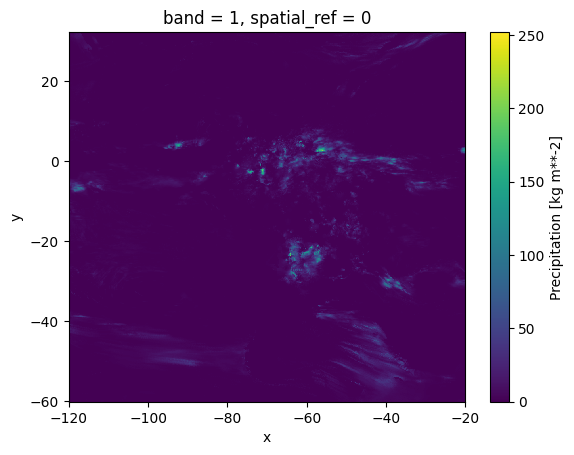

In [14]:
ds.plot()

In [26]:
import geopandas as gpd
import contextily as cx

In [27]:
world_path = gpd.datasets.get_path('naturalearth_lowres')

In [28]:
world = gpd.read_file(world_path)
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In [30]:
import rasterio as rio

In [31]:
chuva = rio.open(file)

In [32]:
chuva.read_transform()

[-120.10000000000001, 0.1, 0.0, -60.099999999999994, 0.0, 0.09999999999999999]

In [47]:
data = chuva.read()

In [48]:
data.shape

(1, 924, 1001)

In [54]:
import numpy as np 


In [56]:
data[:, :, :] = np.linspace(0, 1, 1001)

In [62]:
data[:, 400:500, 700:800] = 1

In [63]:
data

array([[[0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
        [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
        [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
        ...,
        [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
        [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ],
        [0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]]], dtype=float32)

In [64]:
with rio.open('../tmp/output_raster.tif', 'w', **chuva.meta) as dst:
    dst.write(data)

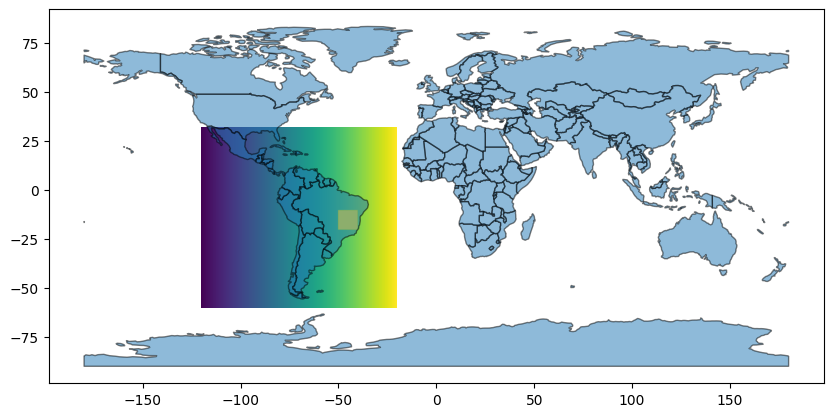

In [65]:
ax = world.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source='../tmp/output_raster.tif', crs=chuva.crs, reset_extent=False, vmin=0, vmax=1)

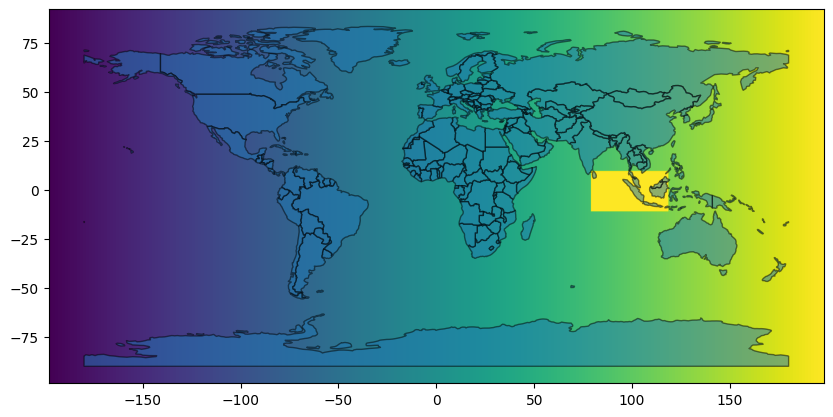

In [66]:
ax = world.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source='../tmp/output_raster.tif', crs=chuva.crs, reset_extent=True, vmin=0, vmax=1)

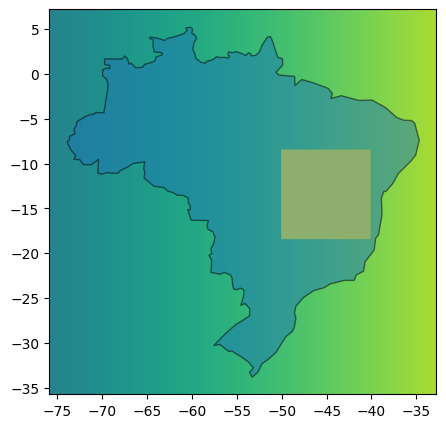

In [68]:
bra = world.query("iso_a3 == 'BRA'")
ax = bra.plot(figsize=(5, 5), alpha=0.5, edgecolor='k')

cx.add_basemap(ax, source='../tmp/output_raster.tif', crs=chuva.crs, reset_extent=True, vmin=0, vmax=1)

TODO: 
* Write the tests for the inpe.py
* Write the docstrings accordingly
* Check Visual Studio auto test not working
* Prepare console calling



In [41]:
chuva.window_bounds()

TypeError: window_bounds() missing 1 required positional argument: 'window'

In [37]:
world.bounds

,minx,miny,maxx,maxy
0,-180.000000,-18.287990,180.000000,-16.020882
1,29.339998,-11.720938,40.316590,-0.950000
2,-17.063423,20.999752,-8.665124,27.656426
3,-140.997780,41.675105,-52.648099,83.233240
4,-171.791111,18.916190,-66.964660,71.357764
...,...,...,...,...
172,18.829825,42.245224,22.986019,46.171730
173,18.450017,41.877551,20.339800,43.523840
174,20.070700,41.847110,21.775050,43.272050
175,-61.950000,10.000000,-60.895000,10.890000


## Opening the rain GRIB

In [7]:
import xarray as xr

In [9]:
ds = xr.open_dataset(file)

In [12]:
ds.assign_coords(longitude=ds.longitude - 360)

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-03-08T17:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
from enum import Enum, auto
class Color(Enum):
    RED = auto()
    GREEN = auto()
    BLUE = auto()


In [16]:
color = Color.RED

In [26]:
color.GREEN.value

2

In [22]:
color == Color.RED

False

In [1]:
from enum import Enum
class FileType(Enum):
    """Specifies the file types for downloading"""

    GRIB = ".grib2"
    GEOTIFF = ".tif"

In [2]:
for ext in FileType:
    print(ext)

FileType.GRIB
FileType.GEOTIFF


In [6]:
ext.value

'.tif'

In [7]:
from unittest.mock import MagicMock

In [14]:
mock = MagicMock()

In [15]:
mock.datetime.today.return_value=0

In [16]:
mock.datetime.today()

0

In [17]:
mock(2)

<MagicMock name='mock()' id='4974278832'>

In [18]:
mock.return_value = True

In [19]:
mock(2)

True

In [21]:
mock.call_args_list

[call(2), call(2)]

In [22]:
mock.called

True

In [29]:
mock(3, x=4)

True

In [30]:
mock.call_args

call(3, x=4)

In [31]:
args = mock.call_args

In [32]:
args.args

(3,)

In [33]:
args.kwargs

{'x': 4}

In [35]:
def test(*args):
    return args

In [37]:
test(3, x=4)

TypeError: test() got an unexpected keyword argument 'x'

In [54]:
from unittest.mock import MagicMock

def my_mock_logic(*args, **kwargs):
    # custom logic to compute the return value
    return sum(args) + sum(kwargs.values())

mock_object = MagicMock(wraps=my_mock_logic)
# mock_object.side_effect = my_mock_logic

# Call the mock object with some arguments and store the return value
result = mock_object(1, 2, a=3, b=4)

# The result should be 10 (1 + 2 + 3 + 4)
assert result == 10

In [51]:
result

<MagicMock name='mock()()' id='4429917344'>

In [47]:
from unittest.mock import MagicMock

class MyMockObject:
    def __call__(self, *args, **kwargs):
        # custom logic to compute the return value
        return sum(args) + sum(kwargs.values())

mock_object = MagicMock(spec=MyMockObject)
mock_object.__call__ = MyMockObject().__call__

# Call the mock object with some arguments
result = mock_object(1, 2, a=3, b=4)

# The result should be 10 (1 + 2 + 3 + 4)
assert result == 10

AssertionError: 

In [48]:
result

<MagicMock name='mock()' id='4429664064'>

In [42]:
mock_object(1, 2, a=3, b=4)

<function __main__.my_mock_logic(*args, **kwargs)>

In [43]:
mock_object.__call__

<function __main__.my_mock_logic(*args, **kwargs)>